# GAN model with auxiliary regresor
##### Script for training model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
NAME="GAN_aux_reg"

### Connect to google colab

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/praca_mgr'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data

In [4]:
# load the dataset
data = load('./data/data_nonrandom_responses.npz')["arr_0"]
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = load('./data/data_nonrandom_particles.npz')["arr_0"]
data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
COND_DIM=data_cond.shape[-1]
print('Loaded cond: ',  data_cond.shape)

data_poz = load("./data/data_nonrandom_position.npz")["arr_0"]
data_poz = pd.DataFrame(data_poz, columns = ["mass_centre_x",	"mass_centre_y",	"mass_max_x",	"mass_max_y",	"mass_size",	"mass_sum"])
print('Loaded poz: ',  data_poz.shape)

Loaded:  (295867, 44, 44) max: 591.0
Loaded cond:  (295867, 9)
Loaded poz:  (295867, 6)


In [ ]:
# # load small dataset
# data = load('./data/data_nonrandom_responses.npz')["arr_0"][:10000]
# print('Loaded: ',  data.shape, "max:", data.max())

# data_cond = load('./data/data_nonrandom_particles.npz')["arr_0"][:10000]
# data_cond = pd.DataFrame(data_cond, columns =['Energy','Vx','Vy',	'Vz',	'Px',	'Py',	'Pz',	'mass',	'charge'])
# COND_DIM=data_cond.shape[-1]
# print('Loaded cond: ',  data_cond.shape)

# data_poz = load("./data/data_nonrandom_position.npz")["arr_0"][:10000]
# data_poz = pd.DataFrame(data_poz, columns = ["mass_centre_x",	"mass_centre_y",	"mass_max_x",	"mass_max_y",	"mass_size",	"mass_sum"])
# print('Loaded poz: ',  data_poz.shape)

In [5]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

scaler_poz = StandardScaler()
data_xy= np.float32(data_poz.copy()[["mass_max_x",	"mass_max_y"]])
data_xy = scaler_poz.fit_transform(data_xy)
print('Load', data_xy.shape,"cond max", data_xy.max(), "min", data_xy.min())

data max 6.383507 min 0.0
cond max 10.15001 min -20.507631
Load (295867, 2) cond max 1.6463951 min -1.852674


In [6]:
x_train, x_test, y_train, y_test, poz_train, poz_test, xy_train, xy_test = train_test_split(data, data_cond, data_poz, data_xy, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, poz_train.shape, poz_test.shape, xy_train.shape, xy_test.shape)

(236693, 44, 44) (59174, 44, 44) (236693, 9) (59174, 9) (236693, 6) (59174, 6) (236693, 2) (59174, 2)


In [7]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.5.0


In [8]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
xy_cond = tf.data.Dataset.from_tensor_slices(xy_train)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train)
fake_with_xy_cond= tf.data.Dataset.zip((fake_cond,xy_cond)).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond, fake_with_xy_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_xy_cond = tf.data.Dataset.from_tensor_slices(xy_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_fake_with_xy_cond= tf.data.Dataset.zip((val_fake_cond,val_xy_cond)).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond,val_fake_with_xy_cond)).shuffle(12800)

### Define model

In [9]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [10]:
latent_dim = 10
cond_dim = 9
poz_dim = 6


############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])
layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(128*13*13)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
reshaped = Reshape((13,13,128))(layer_2_a)
reshaped_s = UpSampling2D()(reshaped)
conv1 = Conv2D(128, kernel_size=3)(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D()(conv1_a)
conv2 = Conv2D(64, kernel_size=3)(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
outputs = Conv2D(1, kernel_size=3,activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[44,44,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], outputs, name='discriminator')
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 19)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          5120        concatenate[0][0]        

In [11]:
#LOAD AUXILIARY REGRESRO
reg = tf.keras.models.load_model('./models/aux_regresor.h5')
reg.summary()
reg.trainable=False

Model: "reg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 44, 44, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 41, 41, 32)        544       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 64)        32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 19, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200  

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [13]:
def generator_loss(step, fake_output, generated_images, generated_images2, noise, noise2):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [14]:
def regressor_loss(real_labels, fake_labels):
  return tf.reduce_mean(tf.keras.losses.MSE(real_labels, fake_labels))

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [18]:
def generator_loss(step, fake_output):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [21]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,44,44)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
  ws= [0,0,0,0,0]
  for j in range(n_calc):
    z = np.random.normal(0,1,(x_test.shape[0],10))
    z_c = y_test
    results = generator.predict([z,z_c])
    results = np.exp(results)-1
    try:
      ch_gen = np.array(results).reshape(-1,44,44)
      ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
      for i in range(5):
        ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
      ws =np.array(ws)
    except ValueError as e:
      print(e)
  ws = ws/n_calc
  print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
  for n,score in enumerate(ws):
    print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch,step):
    images, cond, noise_cond_with_xy = batch
    noise_cond, xy_true = noise_cond_with_xy
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise,noise_cond], training=True)

      real_output = discriminator([images,cond], training=True)
      fake_output = discriminator([generated_images, noise_cond], training=True)

      gen_loss = generator_loss(step,fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      xy_fake= reg(generated_images, training=True)

      # Calculate the generator loss with reg_loss
      g_loss_reg = regressor_loss(xy_true, xy_fake)
      gen_loss_full = gen_loss + g_loss_reg
      
    gradients_of_generator = gen_tape.gradient(gen_loss_full, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, g_loss_reg


In [23]:
history = []
def train(dataset, epochs):
  tf_step =tf.Variable(0, dtype=float)
  step=0
  generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])

  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      gen_loss, disc_loss, reg_loss =train_step(batch,tf_step)
      history.append([gen_loss,disc_loss,
            100*d_acc_r.result().numpy(),
            100*d_acc_f.result().numpy(),
            100*g_acc.result().numpy(),
            ])
      tf_step.assign_add(1)
      step = step+1

      if step%100==0:
        print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] [Reg: %.2f] "% (
            step,
            100*d_acc_r.result().numpy(),
            100*d_acc_f.result().numpy(),
            100*g_acc.result().numpy(),
            reg_loss))
        
      if step%1000==0:
          generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])


    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, seed_cond]
                             )

    # Save the model every epoch
    generator.save_weights("gen_"+NAME + "_"+ str(epoch) +".h5")
    discriminator.save_weights("disc_"+NAME + "_"+ str(epoch) +".h5")
    np.savez("history_"+NAME+".npz",np.array(history))

    calculate_ws_ch(min(epoch//5+1,5))

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return history

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig, axs = plt.subplots(2, 7, figsize=(15,4))
  for i in range(0,14):
    if i <7:
        x = x_test[20+i].reshape(44,44)
    else:
        x = predictions[i-7].numpy().reshape(44,44)
    #x[x<=0]=x.max()*-0.1
    im = axs[i//7,i%7].imshow(x,interpolation='none', cmap='gnuplot')
    axs[i//7,i%7].axis('off')
    fig.colorbar(im, ax=axs[i//7,i%7])
  plt.show()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

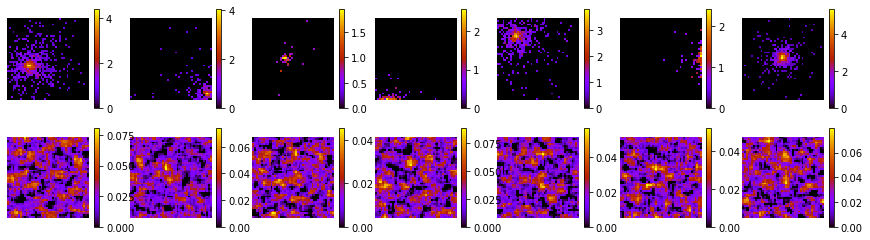

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


100 [D real acc: 57.60%] [D fake acc: 49.66%] [G acc: 50.34%] [Reg: 0.43] 
200 [D real acc: 58.88%] [D fake acc: 49.54%] [G acc: 50.46%] [Reg: 0.45] 
300 [D real acc: 59.96%] [D fake acc: 51.17%] [G acc: 48.83%] [Reg: 0.37] 
400 [D real acc: 60.91%] [D fake acc: 52.53%] [G acc: 47.47%] [Reg: 0.30] 
500 [D real acc: 61.38%] [D fake acc: 53.40%] [G acc: 46.60%] [Reg: 0.22] 
600 [D real acc: 62.03%] [D fake acc: 54.30%] [G acc: 45.70%] [Reg: 0.29] 
700 [D real acc: 62.65%] [D fake acc: 55.28%] [G acc: 44.72%] [Reg: 0.22] 
800 [D real acc: 63.36%] [D fake acc: 56.04%] [G acc: 43.96%] [Reg: 0.33] 
900 [D real acc: 63.80%] [D fake acc: 56.87%] [G acc: 43.13%] [Reg: 0.34] 
1000 [D real acc: 64.10%] [D fake acc: 57.50%] [G acc: 42.50%] [Reg: 0.31] 


<Figure size 432x288 with 0 Axes>

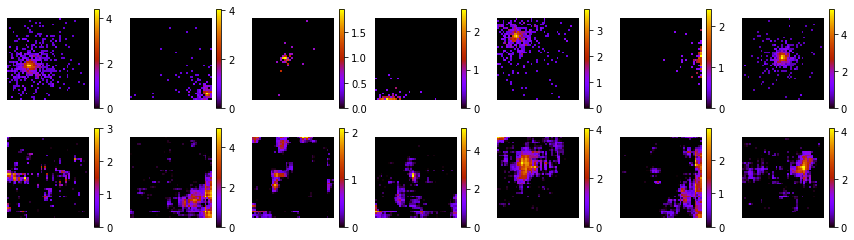

1100 [D real acc: 64.41%] [D fake acc: 58.27%] [G acc: 41.73%] [Reg: 0.31] 
1200 [D real acc: 64.73%] [D fake acc: 58.96%] [G acc: 41.04%] [Reg: 0.38] 
1300 [D real acc: 64.97%] [D fake acc: 59.62%] [G acc: 40.38%] [Reg: 0.33] 
1400 [D real acc: 65.31%] [D fake acc: 60.13%] [G acc: 39.87%] [Reg: 0.29] 
1500 [D real acc: 65.66%] [D fake acc: 60.70%] [G acc: 39.30%] [Reg: 0.34] 
1600 [D real acc: 65.99%] [D fake acc: 61.20%] [G acc: 38.80%] [Reg: 0.23] 
1700 [D real acc: 66.22%] [D fake acc: 61.78%] [G acc: 38.22%] [Reg: 0.40] 
1800 [D real acc: 66.53%] [D fake acc: 62.21%] [G acc: 37.79%] [Reg: 0.25] 


<Figure size 432x288 with 0 Axes>

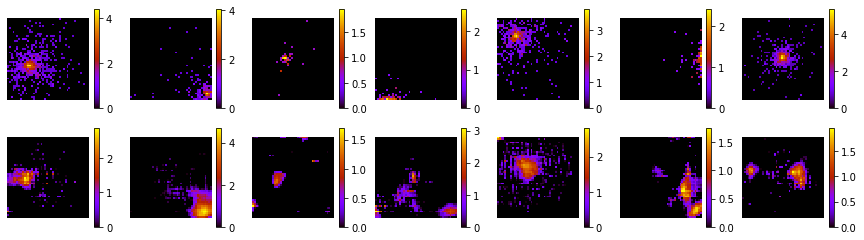

ws mean 55.38 ch1 25.31 ch2 30.93 ch3 16.25 ch4 79.85 ch5 124.57 Time for epoch 1 is 75.55634236335754 sec


<Figure size 432x288 with 0 Axes>

In [25]:
history=train(dataset_with_cond, 1)

### Load best model described in thesis

In [27]:
generator=tf.keras.models.load_model('./models/generator_GAN_aux_reg.h5')

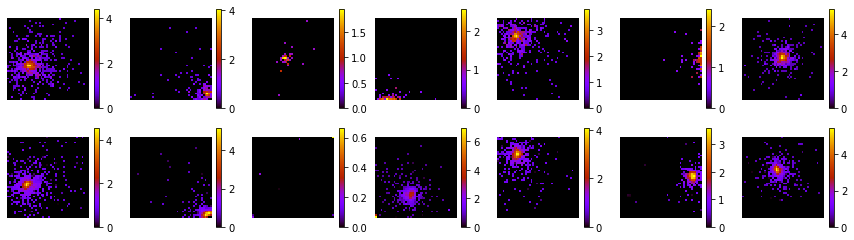

ws mean 7.21 ch1 4.26 ch2 8.44 ch3 3.56 ch4 4.58 ch5 15.23 

<Figure size 432x288 with 0 Axes>

In [28]:
generate_and_save_images(generator,
                          65,
                          [seed, seed_cond]
                          )
calculate_ws_ch(5)